# Water Dimer

In [1]:
#from openmmtools.testsystems import WaterCluster
#help(WaterCluster)


## Simulate

In [2]:
import bgflow as bg
import bgmol
from openmm.unit import kilojoule_per_mole as kjmol, nanometer as nm

harmonic_restraint = 3 * kjmol/nm**2
system = bgmol.system_by_name('WaterCluster', n_waters=2, K=harmonic_restraint)

In [3]:
import os
from tqdm.auto import tqdm
import mdtraj as md

def simulate(system=system):
    simulation = system.create_openmm_simulation(temperature=300.)
    simulation.reporters.extend(system.create_openmm_reporters(out_stub='waters', interval=500))
    for _ in tqdm(range(10000)):
        simulation.step(500)
    del simulation

    
if not os.path.isfile('waters.h5'):
    simulate(system)
    
traj = md.load('waters.h5')

## Show 

In [4]:
import nglview as nv
import numpy as np
from matplotlib import pyplot as plt


def make_traj(traj, system):    
    if isinstance(traj, md.Trajectory):
        return traj
    else:
        return md.Trajectory(
            bg.utils.as_numpy(traj).reshape(-1,6,3),
            topology=system.mdtraj_topology
        )
    
def compute_distances(traj):
    return md.compute_distances(traj, [[0,3]], periodic=False)
    
def plot_distances(distances):
    fig, ax = plt.subplots(1, 3, figsize=(12,2))
    hist, edges = np.histogram(distances, bins=np.linspace(0,0.5,200), density=True)
    centers = 0.5*(edges[1:] + edges[:-1])
    ax[0].plot(distances)
    ax[1].plot(centers, hist)
    pmf = -np.log(hist)
    ax[2].plot(centers, pmf - pmf.min())
    ax[0].set_title('O-O distance (time series)')
    ax[1].set_title('(histogram)')
    ax[1].set_xlim(0,0.5)
    ax[2].set_title('(PMF)')
    ax[2].set_xlim(0,0.5)
    
def show_traj(traj):
    widget = nv.show_mdtraj(traj)
    return widget

/tmp/ipykernel_658569/2622619898.py:24: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist)


NGLWidget(max_frame=9999)

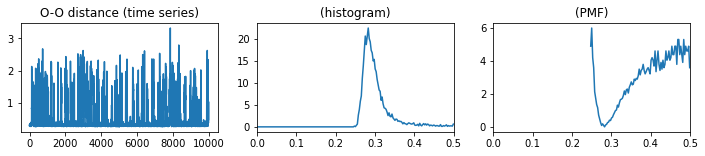

In [5]:
plot_distances(compute_distances(traj))
show_traj(traj)

## Set up IC

In [6]:
import numpy as np
import torch

z_matrix = np.array(
    [[0,-1,-1,-1], [1, 0,-1, -1], [2, 1, 0,-1], [3, 0, 2, 1], [4, 3, 2, 1], [5, 4, 3, 2], ]
)
ic = bg.GlobalInternalCoordinateTransformation(z_matrix)
md_data = torch.as_tensor(traj.xyz.reshape(-1,18))
bonds, angles, torsions, origin, rotation, dlogp = ic.forward(md_data)

/srv/public/kraemea88/coding/bgflow/bgflow/nn/flow/crd_transform/ic_helper.py:283: UserWarning: singular division in torsion computation
  warnings.warn("singular division in torsion computation")


/tmp/ipykernel_658569/2622619898.py:24: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist)


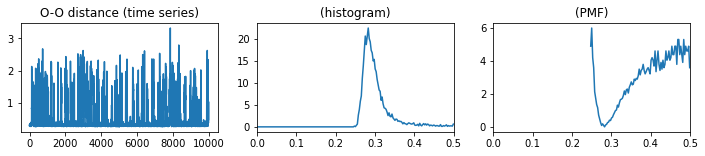

In [7]:
plot_distances(bonds[:,2].detach())

## Train Boltzmann Generator

In [8]:
constraints, lengths = bgmol.bond_constraints(system.system, ic)
shapes = bg.ShapeDictionary.from_coordinate_transform(ic, n_constraints=len(constraints))
ctx = dict(device=torch.device('cpu'), dtype=torch.float32)
builder = bg.BoltzmannGeneratorBuilder(shapes, target=system.energy_model, **ctx)

for i in range(5):
    builder.add_condition(bg.TORSIONS, (bg.BONDS, bg.ANGLES))
    builder.add_condition((bg.BONDS, bg.ANGLES), (bg.TORSIONS))

builder.add_map_to_ic_domains()
builder.add_merge_constraints(constraints, lengths)
builder.add_map_to_cartesian(ic)

generator = builder.build_generator()

/srv/public/kraemea88/coding/bgmol/bgmol/util/ff.py:447: UserWarning: Bond frozenset({0, 3}) not found in force field.
  warnings.warn(f"Bond {bond} not found in force field.", UserWarning)
/srv/public/kraemea88/coding/bgflow/bgflow/distribution/energy/openmm.py:197: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.
  warnings.warn(


In [9]:
optim = torch.optim.Adam(generator.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 1, 0.6)
trainer = bg.KLTrainer(generator, optim=optim, train_energy=False)

In [10]:
for _ in tqdm(range(5)):
    trainer.train(100, md_data, batchsize=512, n_print=50, schedulers=[(50, scheduler)])

  0%|          | 0/5 [00:00<?, ?it/s]

/srv/public/kraemea88/software/anaconda3/envs/oct21/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/srv/public/kraemea88/coding/bgflow/bgflow/nn/flow/crd_transform/ic_helper.py:283: UserWarning: singular division in torsion computation
  warnings.warn("singular division in torsion computation")


1	NLL: -5.5252	
51	NLL: -16.5296	
101	NLL: -17.1486	
151	NLL: -18.9186	
201	NLL: -20.9844	
251	NLL: -22.8425	
301	NLL: -23.3267	
351	NLL: -23.5818	
401	NLL: -23.3383	
451	NLL: -23.6436	


In [11]:
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 6.046617599999998e-06
    weight_decay: 0
)

In [12]:
bg_samples = generator.sample(10000)
bg_traj = md.Trajectory(bg_samples.reshape(-1,6,3).detach().numpy(), system.mdtraj_topology)

/tmp/ipykernel_658569/2622619898.py:24: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist)


NGLWidget(max_frame=9999)

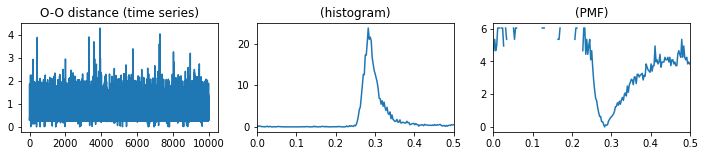

In [13]:
plot_distances(compute_distances(bg_traj))
show_traj(bg_traj)

## Analyze Energies


Now, the Boltzmann generator and the target distribution match quite well.

We check that the volume term is taken into account when computing energies.


In [14]:
md_energies = system.energy(md_data).flatten().detach().numpy()
bg_energies = generator.energy(md_data).flatten().detach().numpy()
md_forces = system.energy_model.force(md_data).detach().numpy()
bg_forces = generator.force(md_data).detach().numpy()
md_distances = md.compute_distances(traj, [[0,3]], periodic=False).flatten()

/srv/public/kraemea88/coding/bgflow/bgflow/nn/flow/crd_transform/ic_helper.py:283: UserWarning: singular division in torsion computation
  warnings.warn("singular division in torsion computation")


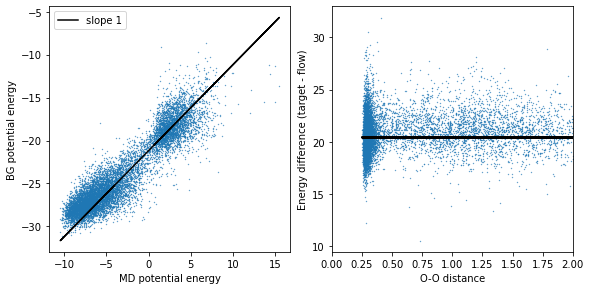

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
fig.tight_layout()

ax = axes[0]
ax.scatter(md_energies, bg_energies, s=0.1)
slope, offset = np.polyfit(md_energies, bg_energies, 1)
ax.plot(md_energies, md_energies + offset, color='black', label="slope 1")
ax.legend(loc="upper left")
ax.set_xlabel('MD potential energy')
_ = ax.set_ylabel('BG potential energy')


ax = axes[1]
ax.scatter(md_distances, md_energies - bg_energies, s=0.1)
slope, offset = np.polyfit(md_distances, md_energies - bg_energies, 1)
ax.set_xlim(0, 2)
ax.plot(md_distances, 0*md_distances + offset, color='black', label="slope 0")
ax.set_xlabel('O-O distance')
_ = ax.set_ylabel('Energy difference (target - flow)')


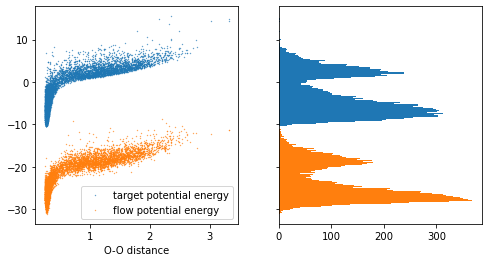

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(8,4), sharey=True)

ax = axes[1]
_ = ax.hist(md_energies, bins=100, orientation="horizontal")
_ = ax.hist(bg_energies, bins=100, orientation="horizontal")

ax = axes[0]
_ = ax.scatter(md_distances, md_energies, s=0.1, label='target potential energy')
_ = ax.scatter(md_distances, bg_energies, s=0.1, label='flow potential energy')
ax.set_xlabel('O-O distance')

ax.legend()